In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

# Upload kaggle API key file
uploaded = files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v
!kaggle datasets download -d paultimothymooney/breast-histopathology-images


In [0]:
!unzip \*.zip 

In [3]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import fnmatch
from glob import glob
%matplotlib inline 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import keras
import tensorflow
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization,Conv2D,MaxPool2D,MaxPooling2D
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score

Using TensorFlow backend.


In [0]:
from glob import glob
images=glob('../content/IDC_regular_ps50_idx5/**/*.png',recursive=True)

In [0]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(images, patternZero)
classOne = fnmatch.filter(images, patternOne)

In [0]:
import numpy as np
def process_images(lowerIndex,upperIndex):
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    count = 0
    for img in images[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
        if(count%10000==0):
            print(count)
        count +=1
    return x,y

X,Y=process_images(0,150000)

#X1=np.array(X)
#print(X1.shape)
#df = pd.DataFrame()
#df["images"]=X
#df["labels"]=Y
#X2=df["images"]
#Y2=df["labels"]
#X2=np.array(X2)

# Separation of classes of images
#imgs0=[]
#imgs1=[]
#imgs0 = X2[Y2==0]
#imgs1 = X2[Y2==1] 

#print number of elements in eachi class label
#print('Total number of images: {}'.format(len(X2)))
#print('Number of Class 0 images: {}'.format(np.sum(Y2==0)))
#print('Number of class 1 Images: {}'.format(np.sum(Y2==1)))
#print('Image shape (Width, Height, Channels): {}'.format(X1[0].shape))

X=np.array(X)

#Standarizing the data for the model 
X=X/255.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)

In [8]:
del X
import gc
y_trainCat=to_categorical(Y_train,num_classes=2)
y_testCat=to_categorical(Y_test,num_classes=2)
gc.collect()

22

In [0]:
# Helper Functions  Learning Curves and Confusion Matrix

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

In [0]:
batch_size = 128
num_classes = 2
epochs = 10
img_rows,img_cols=50,50
input_shape = (img_rows, img_cols, 3)
e = 2

In [0]:
from keras.models import Sequential #for neural network models
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator #Data augmentation and preprocessing
from keras.utils import to_categorical #For One-hot Encoding
from keras.optimizers import Adam, SGD, RMSprop #For Optimizing the Neural Network
from keras.callbacks import EarlyStopping
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(50,50,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
#Viewing the summary of the model
model.summary()

In [13]:
optimizer = Adam(lr = 0.0001)
early_stopping_monitor = EarlyStopping(patience = 10, monitor = "val_accuracy", mode="max", verbose = 2)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
history = model.fit_generator(epochs=50, verbose = 1, callbacks=[early_stopping_monitor], shuffle=True, validation_data=(X_test,y_testCat), generator=datagen.flow(X_train,y_trainCat), steps_per_epoch=500, validation_steps=10)
prediction = model.predict_generator(generator=datagen.flow(X_train,y_trainCat), verbose=2, steps=100)

Epoch 1/50
500/500 [==============================] - 50s 100ms/step - loss: 0.5271 - accuracy: 0.7616 - val_loss: 0.4177 - val_accuracy: 0.8197
Epoch 2/50
500/500 [==============================] - 42s 84ms/step - loss: 0.4284 - accuracy: 0.8209 - val_loss: 0.4476 - val_accuracy: 0.7987
Epoch 3/50
500/500 [==============================] - 44s 89ms/step - loss: 0.4150 - accuracy: 0.8179 - val_loss: 0.4033 - val_accuracy: 0.8242
Epoch 4/50
500/500 [==============================] - 43s 86ms/step - loss: 0.3968 - accuracy: 0.8276 - val_loss: 0.4202 - val_accuracy: 0.8170
Epoch 5/50
500/500 [==============================] - 42s 83ms/step - loss: 0.3950 - accuracy: 0.8299 - val_loss: 0.3683 - val_accuracy: 0.8438
Epoch 6/50
500/500 [==============================] - 42s 83ms/step - loss: 0.3825 - accuracy: 0.8366 - val_loss: 0.3703 - val_accuracy: 0.8435
Epoch 7/50
500/500 [==============================] - 44s 88ms/step - loss: 0.3736 - accuracy: 0.8406 - val_loss: 0.3586 - val_accuracy

In [14]:
import gc
gc.collect()

43

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


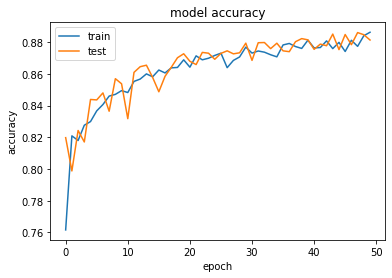

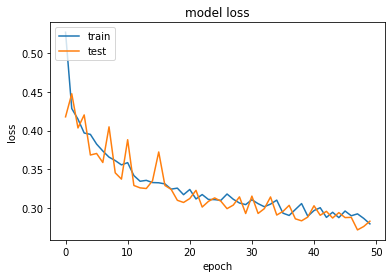

In [15]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
test_filenames = glob('/content/13400/1/*.png')
import tensorflow as tf
from google.colab.patches import cv2
#test_filenames.append(glob('/content/12868/1/*.png'))
test_samples = []
for x in test_filenames:
    u = cv2.imread(x)
    test_samples.append(cv2.resize(u, (50,50), interpolation=cv2.INTER_CUBIC))
test_samples = np.array(test_samples)

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow(
    test_samples, 
    batch_size=batch_size,
    shuffle=False
)
predict = model.predict_generator(test_generator)
predict = np.argmax(predict, axis=-1)

count_tn = 0
count_fp = 0
count_tp = 0
count_fn = 0
#for i in predict:
#    if(i==0):
#        count_tn +=1
#    else:
#        count_fp +=1
#print('TN: ',count_tn)
#print('FP: ',count_fp)
print(predict)
for i in predict:
    if(i==1):
        count_tp +=1
    else:
        count_fn +=1
print('TP: ',count_tp)
print('FN: ',count_fn)


[1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1]
TP:  48
FN:  16


In [0]:
# a = X_train
# b = y_trainHot
# c = X_test
# d = y_testHot
# epochs = 10
y_pred = model.predict(X_test)

In [62]:
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_testCat,axis=1)
print(Y_pred_classes)

[0 1 0 ... 0 0 0]


In [0]:
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

NameError: ignored

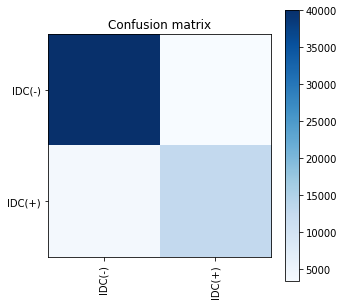

In [64]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()